Let's warm up:

In [1]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
#pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader as web
import datetime
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2021, 1, 30)
aapl = web.DataReader('AAPL', 'yahoo', start, end)
aapl.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.382229
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.559074
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.034378
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.954170
2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.639565
2019-01-09,38.632500,37.407501,37.822498,38.327499,180396400.0,37.261768
2019-01-10,38.492500,37.715000,38.125000,38.450001,143122800.0,37.380867
2019-01-11,38.424999,37.877499,38.220001,38.072498,108092800.0,37.013859
2019-01-14,37.817501,37.305000,37.712502,37.500000,129756800.0,36.457283


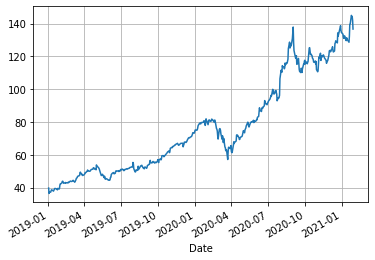

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = aapl['High']
vol.plot()
plt.grid(True)

We can calculate the n-th (n=1 is the default) discrete difference along a given axis to find out about gains/losses, using numpy's [diff](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html) API:

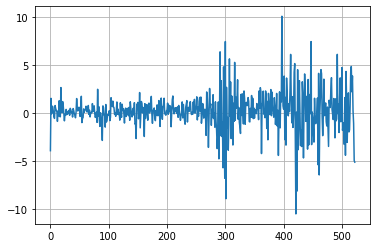

In [11]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)
plt.grid(True)

### Time Series Exploratory Data Analysis (EDA)

A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a **forecast** for the future.

However, there are other aspects that come into play when dealing with time series. Namely:
- Is it **stationary**? Stationarity is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. 

In other words, it has constant **mean** and **variance**, and **covariance** is independent of time. We'll study what these concepts represent when we get into statistics. For now just think of them as point estimates of a distribution of numbers. 

Often, stock prices are ***not a stationary process***, since we might see a growing trend, orits volatility might increase over time (meaning that variance is changing). Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can often make different transformations to make them stationary. 

[Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) is the statistical test that we run to determine if a time series is stationary or not. If you coop for Wall Street or get a job as quant, you'll be running this test *all the time*.


- Is the target variable **autocorrelated**? Autocorrelation is the similarity between observations as a function of the
time lag between them


- Is there a **seasonality**? Seasonality refers to periodic fluctuations. For example, electricity consumption is high
during the day and low during night, or online sales increase during Christmas before slowing down again. seasonality can also be derived from an autocorrelation plot if it has a sinusoidal shape. Simply look at the period, and it gives the length of the season.

# 1. You first time series model: A very shaky model

Let's see if we can predict one column (y) from the same column, but time-shifted by an amount, just like we did with our meteorological dataset in class.

We will train a Random Forest with a sample of our data, then test it with another sample to see how it performs. Let's import the `Scikit-learn` modules.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = aapl
drop_cols = ['Low', 'Open', 'Close', 'Volume', 'Adj Close']

data.drop(drop_cols, axis=1, inplace=True)
data

,High
Date,
2019-01-02,39.712502
2019-01-03,36.430000
2019-01-04,37.137501
2019-01-07,37.207500
2019-01-08,37.955002
...,...
2021-01-25,145.089996
2021-01-26,144.300003
2021-01-27,144.300003


Let's create our dependent variable, and see if we can predict stock price one month in advance:

In [4]:
data['predict'] = data['High'].shift(-30)
data

,High,predict
Date,,
2019-01-02,39.712502,42.814999
2019-01-03,36.430000,42.924999
2019-01-04,37.137501,42.860001
2019-01-07,37.207500,43.330002
2019-01-08,37.955002,43.092499
...,...,...
2021-01-25,145.089996,NaN
2021-01-26,144.300003,NaN
2021-01-27,144.300003,NaN


Let's remove the last 30 rows:

In [5]:
data2 = data[0:-30]
data2

,High,predict
Date,,
2019-01-02,39.712502,42.814999
2019-01-03,36.430000,42.924999
2019-01-04,37.137501,42.860001
2019-01-07,37.207500,43.330002
2019-01-08,37.955002,43.092499
...,...,...
2020-12-09,125.949997,145.089996
2020-12-10,123.870003,144.300003
2020-12-11,122.760002,144.300003


Let's name our independent and dependent variables:

In [6]:
x = data2['High']
y = data2['predict']

In [7]:
x #a pandas Series (of 1 column)

Date
2019-01-02     39.712502
2019-01-03     36.430000
2019-01-04     37.137501
2019-01-07     37.207500
2019-01-08     37.955002
                 ...    
2020-12-09    125.949997
2020-12-10    123.870003
2020-12-11    122.760002
2020-12-14    123.349998
2020-12-15    127.900002
Name: High, Length: 494, dtype: float64

In [8]:
y #a pandas Series (of 1 column)

Date
2019-01-02     42.814999
2019-01-03     42.924999
2019-01-04     42.860001
2019-01-07     43.330002
2019-01-08     43.092499
                 ...    
2020-12-09    145.089996
2020-12-10    144.300003
2020-12-11    144.300003
2020-12-14    141.990005
2020-12-15    136.740005
Name: predict, Length: 494, dtype: float64

Now, the Random forest API, and almost all APIs that have a `.fit()` training method, always expect the independent variables to be a pandas `DataFrame`, whereas the dependent variable can be a Pandas `Series`. In other words, the indepedent variables cannot be a pandas Series!

So what we need to do is to turn them into numpy arrays instead, because the `.fit()` API is polymorphic and works with both pandas DataFrames and numpy arrays, and then use `.reshape(-1,1)` to add a dummy extra dimension.

In [9]:
x.values # a numpy array

array([ 39.71250153,  36.43000031,  37.13750076,  37.20750046,
        37.95500183,  38.63249969,  38.49250031,  38.42499924,
        37.81750107,  38.34749985,  38.97000122,  39.41500092,
        39.47000122,  39.18249893,  38.78499985,  38.61999893,
        39.53250122,  39.08250046,  39.53250122,  41.53749847,
        42.25      ,  42.24499893,  42.91500092,  43.77000046,
        43.89250183,  43.48500061,  42.66500092,  42.80250168,
        42.75      ,  43.11999893,  42.81499863,  42.92499924,
        42.86000061,  43.33000183,  43.09249878,  43.25      ,
        43.96749878,  43.82500076,  43.75      ,  43.72750092,
        43.78749847,  44.4375    ,  44.        ,  43.87250137,
        43.61000061,  43.26750183,  44.77999878,  45.66749954,
        45.82500076,  46.02500153,  46.83250046,  47.09749985,
        47.24750137,  47.37250137,  49.08250046,  49.42250061,
        47.99499893,  48.22000122,  47.43999863,  47.38999939,
        47.52000046,  47.91999817,  48.61500168,  49.12

In [10]:
X = x.values.reshape(-1, 1)
X # a 2D numpy array that is really 1D but has a dummy extra dimension

array([[ 39.71250153],
       [ 36.43000031],
       [ 37.13750076],
       [ 37.20750046],
       [ 37.95500183],
       [ 38.63249969],
       [ 38.49250031],
       [ 38.42499924],
       [ 37.81750107],
       [ 38.34749985],
       [ 38.97000122],
       [ 39.41500092],
       [ 39.47000122],
       [ 39.18249893],
       [ 38.78499985],
       [ 38.61999893],
       [ 39.53250122],
       [ 39.08250046],
       [ 39.53250122],
       [ 41.53749847],
       [ 42.25      ],
       [ 42.24499893],
       [ 42.91500092],
       [ 43.77000046],
       [ 43.89250183],
       [ 43.48500061],
       [ 42.66500092],
       [ 42.80250168],
       [ 42.75      ],
       [ 43.11999893],
       [ 42.81499863],
       [ 42.92499924],
       [ 42.86000061],
       [ 43.33000183],
       [ 43.09249878],
       [ 43.25      ],
       [ 43.96749878],
       [ 43.82500076],
       [ 43.75      ],
       [ 43.72750092],
       [ 43.78749847],
       [ 44.4375    ],
       [ 44.        ],
       [ 43

Now we import `RandomForestRegressor` from the `sk-learn` package. 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

Let's create training and test data:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Now we create a ML model, using `RandomForestRegressor` from the `sk-learn` package, and we train:

In [13]:
# Create a model 
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

Let's score our model at how good it is in predicting stick prices 30 days in the future:

In [14]:
rf_model.score(X_test, y_test)

0.9317058956922699

Wow! 93%!! What the heck am I doing teaching at Northeastern?!! I should quit my job, move to New York City, and play the stock market!

Hmmm.. What do you think the random forest is actually doing?

- It has all the data minus 200 points here and there. So just fill in the blanks with the value right before it (e.g. If you have the data for Wednesday but no the Thursday thereafter, just use the value for Wednesday! Because *for all time series* that are somewhat continuous, the point *before* is a great approximation for the point *after*!)

<br />
<center>
<img src="ipynb.images/x-test-y-test.png" width=700 />
</center>

So the prediction is ***trivial***! What we really need to do is to ***mask the future*** for the model, to force it to look at only the **past**, and not the **future** in making predictions!

Let's do that: Let's pick X\[0:300\] as our training data, and X\[300:500\] as our test data:

In [16]:
X_train = X[:300]
X_test = X[300:]
y_train = y[:300]
y_test = y[300:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((300, 1), (194, 1), (300,), (194,))

In [55]:
type(y_train)

pandas.core.series.Series

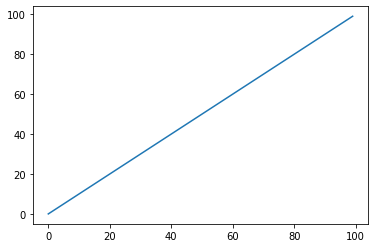

In [63]:
plt.plot(list(range(0,100)), list(range(0,100)))

In [69]:
len(X_train), len(X_test)

(300, 194)

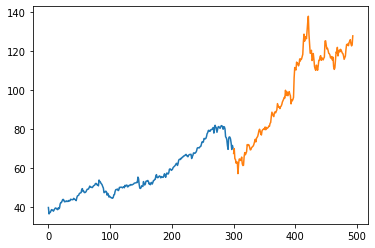

In [73]:
plt.plot(list(range(0,300)), X_train, )
plt.plot(list(range(300,300+194)), X_test)

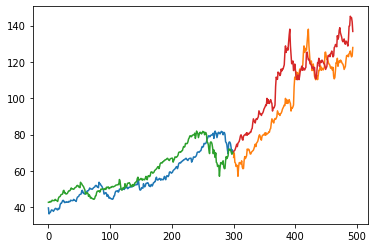

In [74]:
plt.plot(list(range(0,300)), X_train, )
plt.plot(list(range(300,300+194)), X_test)
plt.plot(list(range(0,300)), y_train, )
plt.plot(list(range(300,300+194)), y_test)

In [17]:
# Create a model 
rf_model2 = RandomForestRegressor()

# Train the model
rf_model2.fit(X_train, y_train)

# Score the model
rf_model2.score(X_test, y_test)

-4.957127571754278

Uh oh.... Our model sucks now!

>***We cannot predict the future unless it is somehow correlated with the past!***

Just out of curiosity, let's see what we predict:

In [18]:
y_pred = rf_model2.predict(X_test)

In [19]:
type(y_test)

pandas.core.series.Series

In [20]:
type(y_pred)

numpy.ndarray

If the types above are *different*. you need to convert either y_test or `y_pred` into the sme type to be able to plot the data. Let's say we convert to a pandas dataframe, this is how to do it:
```(python)
y_pred_df = pd.DataFrame(y_pred, columns=['CLOSE'], index=y_test.index)
```

In [21]:
y_pred_df = pd.DataFrame(y_pred, columns=['CLOSE'], index=y_test.index)

In [22]:
type(y_pred_df)

pandas.core.frame.DataFrame

Let's plot what we predict:

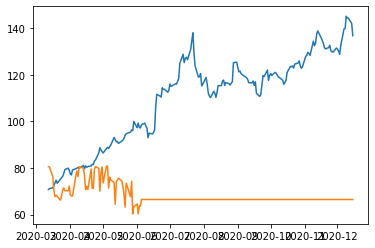

In [23]:
plt.plot(y_test)
plt.plot(y_pred_df)

Awful!

<br />
<center>
<img src="ipynb.images/garfield-oh-no.png" width=200 />
</center>

How about we use a different ML algorithm, like a Support Vector Machine (SVM), for example? We haven't seen this yet in class, but when I google, it looks like a lot of people are using SVMs for time series analysis...

In [41]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [42]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [43]:
type(y_test)

pandas.core.series.Series

In [44]:
type(y_pred)

numpy.ndarray

In [45]:
y_pred_df = pd.DataFrame(y_pred, columns=['High'], index=y_test.index)

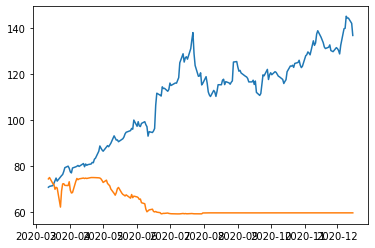

In [46]:
plt.plot(y_test)
plt.plot(y_pred_df)

Better in the beginning, but then awful, too!
<br />
<center>
<img src="ipynb.images/garfield-oh-no.png" width=200 />
</center>

Ok, how about a Neural Network? I hear that neural networks are pretty cool for time series.

We'll learn about Artificial Neural Networks much later in class, this is just a preview.

For this to work, you will need tensorflow. If your `pip install`s do not work, you can wait for when we do this in class, or you can ask your TAs :-)

```(python)
pip install tensorflow
```

>**Hint**: I'm using an older version of tensorflow (the 1.x version). Most of you will download the 2.x version, so you will probably need to replace
```(python)
from keras.models import Sequential
```
with
```(python)
from tensorflow.keras.models import Sequential
```
below.

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.
d:\Anaconda3.5.1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Anaconda3.5.1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Anaconda3.5.1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\Anaconda3.5.1\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (ty

We'll use one hidden layer with one Neuron, and 100 timesteps of training, in batches of 16 timesteps:

In [47]:
#K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=1)

Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 3740.9113
Epoch 2/100
300/300 [==============================] - 0s 85us/step - loss: 3740.9113
Epoch 3/100
300/300 [==============================] - 0s 78us/step - loss: 3740.9113
Epoch 4/100
300/300 [==============================] - 0s 72us/step - loss: 3740.9113
Epoch 5/100
300/300 [==============================] - 0s 68us/step - loss: 3740.9113
Epoch 6/100
300/300 [==============================] - 0s 87us/step - loss: 3740.9113
Epoch 7/100
300/300 [==============================] - 0s 94us/step - loss: 3740.9113
Epoch 8/100
300/300 [==============================] - 0s 78us/step - loss: 3740.9113
Epoch 9/100
300/300 [==============================] - 0s 75us/step - loss: 3740.9113
Epoch 10/100
300/300 [==============================] - 0s 65us/step - loss: 3740.9114
Epoch 11/100
300/300 [==============================] - 0s 65us/step - loss: 3740.9113
Epoch 12/100
300/300 [==============================]

In [48]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -6.442801


Hmmm... Does not look too good, does it?

Let's see if we can predict the test dataset `X_test`:

In [49]:
y_pred = model.predict(X_test)

In [50]:
y_pred_df = pd.DataFrame(y_pred, columns=['High'], index=y_test.index)

R-Squared: -33.019652


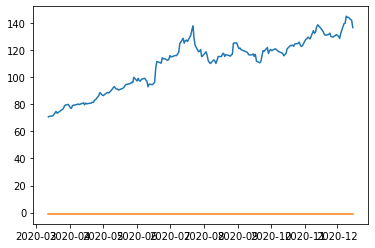

In [51]:
plt.plot(y_test)
plt.plot(y_pred_df)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

Nope, bad!

Hmmm... I hear that ML is all about ***deep*** networks, so how about we increase the *intelligence* of our neural network with **2 Hidden Layers** and **50 neurons each**, and a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function as well?


<br />
<center>
<img src="ipynb.images/champagne-glass-cake.jpg" width=300 />
</center>

In [36]:
#K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=50, verbose=1)

Epoch 1/50
300/300 [==============================] - 1s 4ms/step - loss: 2149.0880
Epoch 2/50
300/300 [==============================] - 0s 153us/step - loss: 94.9756
Epoch 3/50
300/300 [==============================] - 0s 174us/step - loss: 77.9701
Epoch 4/50
300/300 [==============================] - 0s 120us/step - loss: 50.1691
Epoch 5/50
300/300 [==============================] - 0s 101us/step - loss: 49.4264
Epoch 6/50
300/300 [==============================] - 0s 107us/step - loss: 49.5540
Epoch 7/50
300/300 [==============================] - 0s 117us/step - loss: 49.3915
Epoch 8/50
300/300 [==============================] - 0s 107us/step - loss: 49.5263
Epoch 9/50
300/300 [==============================] - 0s 138us/step - loss: 49.5549
Epoch 10/50
300/300 [==============================] - 0s 127us/step - loss: 50.4613
Epoch 11/50
300/300 [==============================] - 0s 143us/step - loss: 50.6568
Epoch 12/50
300/300 [==============================] - 0s 114us/step - los

In [37]:
y_pred = model.predict(X_test)

In [38]:
y_pred_df = pd.DataFrame(y_pred, columns=['High'], index=y_test.index)

R-Squared: 0.595634


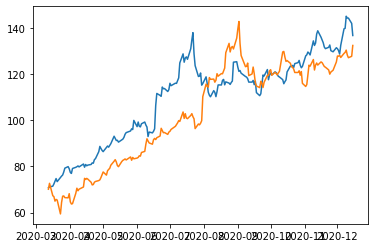

In [39]:
plt.plot(y_test)
plt.plot(y_pred_df)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

Oooooh.. wow, 60%! This model appears to... work?!


First of all, a guess of around 50% is not that great.

But, yay, pretty smart little deep neural network: Training with this data:

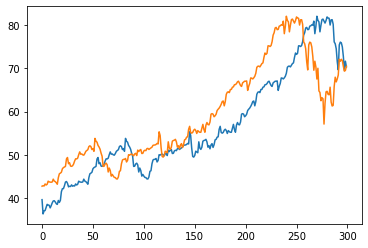

In [76]:
plt.plot(list(range(0,300)), X_train)
plt.plot(list(range(0,300)), y_train)

It learned to do this prediction:

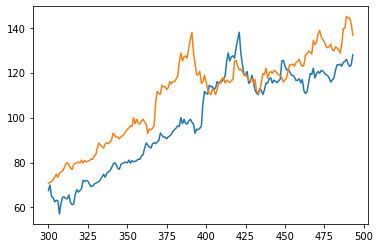

In [77]:
plt.plot(list(range(300,300+194)), X_test)
plt.plot(list(range(300,300+194)), y_test)

In other words it learned that:
- To predict 30 days in advance, shift the curve 30 ticks to the right!

<br />
<center>
<img src="ipynb.images/x-test-x-test-30+.png" width=400 />
</center>

So yes, some of you (and half of the WWW), may have "*predicted*" the time series, but all your model really did is shift the training data 30 clicks to the right.

<br />
<center>
<img src="ipynb.images/duh.gif" width=200 />
</center>

# About Time Series prediction

First of all, a really ***bad*** way to do Machine Learning on financial data is to look for how many days in the past I can predict stock price... ***from the stock price itself***.

You may not predict a dependent variable from the ***same*** variable that you will call ***independent*** in the days prior, unless there is ***autocorrelation*** or you ***first process those historical values in some way***.

<center>
<img src="ipynb.images/oopsie.png" width=300 />
</center>

This is ***bad ML***, and you would be surprised at how many people do that on the Web. 

Why is it flawed? Because it's missing statistical **reasoning**.

Data science is about ***going back in time*** to find the process that yields the data, right? 

The process that yields the price for stock data is ***not the stock price itself***!

The price ***rarely*** decides what the price is ***going*** to be (in the future)! 

It's ***market forces*** that shape the price! So ML should attempt to uncover those market forces! And it probably could, if we give it the *right columns*. But we didn't! We just used the price in the past to attempt to predict the price in the future! 

That is like learning how to land a plane by looking at runway lights (which light up different colors depending on how we're doing, coming in too high or too low), instead of learning how to fly by understanding the dynamics of flight. The too-low lights *don't tell us why we're too low* (*but if you learn to fly just by using a flight simulator, you might just look at runway lights to land the plane*)!

Poor little Machine Learning algorithms will however do its *best* and attempt to predict future price from past price. 

Obviously, the ***best*** predictor of $y$ at time $t$ is $y$ at time $t-1$! So, **day - 1** will always work ***great*** as a predictor for **day 0**, **day - 2** also, albeit less so, and so on until it stops working as we increase the number of days we go in the past. But the best trick is to just learn to shift the data x clicks to the right, and our ***deep*** model learned to do just that.

Neural networks, arguably the *smartest* of all ML algorithms as we increase their intelligence (add more layers and more neurons), will figure out what constitues the *best strategy*, and ***do just that***! So, they ***cheat***!

<br />
<center>
<img src="ipynb.images/oh-no.png" width=200 />
    Oh no!!
</center>

Here is an example of cheat-learning: A Google AI learned how to run, but nobody told it that humans like to conserve energy while running, because energy is in limited quantities for us humans. So the AI learned to balance itself with enormous expenditures of energy, leading to physically unrealistic solutions for balance (look at the arms waving wildly): 

Let's rerun our last neural network:

In [84]:
#K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test4.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test4.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train4, y_train4, batch_size=16, epochs=50, verbose=1)

Epoch 1/50
299/299 [==============================] - 1s 2ms/step - loss: 1.6136
Epoch 2/50
299/299 [==============================] - 0s 75us/step - loss: 1.5077
Epoch 3/50
299/299 [==============================] - 0s 85us/step - loss: 1.4374
Epoch 4/50
299/299 [==============================] - 0s 95us/step - loss: 1.4411
Epoch 5/50
299/299 [==============================] - 0s 85us/step - loss: 1.4291
Epoch 6/50
299/299 [==============================] - 0s 98us/step - loss: 1.4448
Epoch 7/50
299/299 [==============================] - 0s 88us/step - loss: 1.4463
Epoch 8/50
299/299 [==============================] - 0s 78us/step - loss: 1.4286
Epoch 9/50
299/299 [==============================] - 0s 72us/step - loss: 1.4243
Epoch 10/50
299/299 [==============================] - 0s 78us/step - loss: 1.4461
Epoch 11/50
299/299 [==============================] - 0s 62us/step - loss: 1.4477
Epoch 12/50
299/299 [==============================] - 0s 75us/step - loss: 1.4348
Epoch 13/50
29

Let's predict:

In [85]:
y_pred4 = model.predict(X_test4)

In [86]:
type(y_test4)

numpy.ndarray

In [87]:
type(y_pred4)

numpy.ndarray

R-Squared: -0.041923


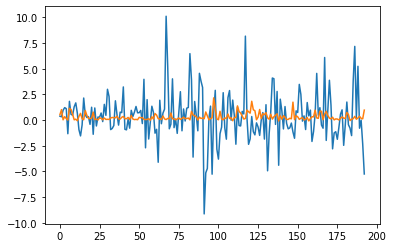

In [88]:
plt.plot(y_test4)
plt.plot(y_pred4)
print('R-Squared: %f'%(r2_score(y_test4, y_pred4)))

***Horrible***! *As expected*!

Prediction of time series from the time series *itself* is ***not possible*** (unless the time series is **autocorrelated**: future behavior is related to past behavior)!  ;-)

So what exactly do [quants](https://en.wikipedia.org/wiki/Quantitative_analysis_(finance)) do on *Wall Street*?

<br />
<center>
<img src="ipynb.images/quants.jpg" width=400 />
A quant making a million dollar salary
</center>

# Financial Indicators

[This](https://www.investopedia.com/articles/active-trading/041814/four-most-commonlyused-indicators-trend-trading.asp) is where I learned about financial indicators. 

Here is what I learned:

##  Price Action
[Price action](https://www.investopedia.com/terms/p/price-action.asp) is the movement of a security's price plotted over time. Price action forms the basis for all technical analysis of a stock, commodity or other asset chart. Many short-term traders rely exclusively on price action and the formations and trends extrapolated from it to make trading decisions. Technical analysis as a practice is a derivative of price action since it uses past prices in calculations that can then be used to inform trading decisions.

### What Does Price Action Tell You?
Price action can be seen and interpreted using charts that plot prices over time. Traders use different chart compositions to improve their ability to spot and interpret trends, breakouts and reversals. Many traders use candlestick charts since they help better visualize price movements by displaying the open, high, low, and close values in the context of up or down sessions.

>**LESSON**: This tells me that it is important to understand price actions in the context of the DOW Jones industrial average. So I plan to add columns that reflect how the DOW is trending.

## What is a Reversal?
A [reversal](https://www.investopedia.com/terms/r/reversal.asp) is a change in the price direction of an asset. A reversal can occur to the upside or downside. Following an uptrend, a reversal would be to the downside. Following a downtrend, a reversal would be to the upside. Reversals are based on overall price direction and are not typically based on one or two periods/bars on a chart.

## Moving Averages
Moving averages ***smooth*** price data by creating a single flowing line. The line represents the average price over a period of time. Which moving average the trader decides to use is determined by the time frame in which he or she trades. For investors and long-term trend followers, the 200-day, 100-day, and 50-day simple moving average are popular choices.

There are several ways to utilize the moving average. The first is to look at the angle of the moving average. If it is mostly moving horizontally for an extended amount of time, then the price isn't trending, it is **ranging**. If the moving average line is angled up, an **uptrend** is underway. 

Moving averages don't predict though. They simply show what the price is doing, on average, over a period of time.

When the price crosses above a moving average, it can also be used as a **buy signal**, and when the price crosses below a moving average, it can be used as a **sell signal**. But since the price is more volatile than the moving average, this method is prone to more false signals, as the chart above shows.

These buy and sell signals are indicators of **latent** variables, hidden yet to be uncovered variables that explain why the stock prize moves up or down.

Many traders will watch for a short-term moving average to cross above a longer-term moving average and use this to signal increasing upward momentum. This bullish crossover suggests that the price has recently been rising at a faster rate than it has in the past, so it is a common technical buy sign. 

Conversely, a short-term moving average crossing below a longer-term average is used to illustrate that the asset's price has been moving downward at a faster rate and that it may be a good time to sell.

Crossovers are another way to utilize moving averages. By plotting a 200-day and 50-day moving average on your chart, a buy signal occurs when the 50-day crosses above the 200-day. A sell signal occurs when the 50-day drops below the 200-day.

That is the basic baseline theory behind how investors buy or sell stock.

## MACD (Moving Average Convergence Divergence)
The [MACD](https://www.investopedia.com/trading/macd/) was designed to profit by analyzing the difference between the two exponential moving averages (EMAs). Specifically, the value for the long-term moving average is subtracted from the short-term average, and the result is plotted onto a chart. The periods used to calculate the MACD can be easily customized to fit any strategy, but traders will commonly rely on the default settings of 12- and 26-day periods.

A positive MACD value, created when the short-term average is above the longer-term average, is used to signal increasing upward momentum. This value can also be used to suggest that traders may want to refrain from taking short positions until a signal suggests it is appropriate. On the other hand, falling negative MACD values suggest that the downtrend is getting stronger, and that it may not be the best time to buy.

One basic MACD strategy is to look at which side of zero the MACD lines are on in the histogram below the chart. Above zero for a sustained period of time, and the trend is likely up; below zero for a sustained period of time, and the trend is likely down. Potential buy signals occur when the MACD moves above zero, and potential sell signals when it crosses below zero.

Signal line crossovers provide additional buy and sell signals. A MACD has two lines – a fast line and a slow line. A buy signal occurs when the fast line crosses through and above the slow line. A sell signal occurs when the fast line crosses through and below the slow line.

The MACD indicator is one of the most popular tools in technical analysis because it gives traders the ability to quickly and easily identify the short-term trend direction. The clear transaction signals help minimize the subjectivity involved in trading, and the crosses over the signal line make it easy for traders to ensure that they are trading in the direction of momentum. Very few indicators in technical analysis have proved to be more reliable than the MACD, and this relatively simple indicator can quickly be incorporated into any short-term trading strategy.

## Volume As An Indicator
Volume is an important indicator in technical analysis as it is used to measure the relative worth of a market move. If the markets make a strong price movement, then the strength of that movement depends on the volume for that period. The higher the volume during the price move, the more significant the move.

**Fundamental analysis** is based on company performance and is used to determine which stock to buy. 

**Technical analysis** is based on stock price and is used to determine when to buy. Technical analysts are primarily looking for entry and exit price points, and volume levels provide clues about where the best entry and exit points are located.

Volume is one of the most important measures of strength for traders and technical analysts. Put simply, volume refers to the number of trades completed. For any trade to occur, the market needs to produce a buyer and a seller. A transaction occurs when buyers and sellers meet and is referred to as the **market price**. From an auction perspective, when buyers and sellers become particularly active at a certain price, it means there is a lot of volume.

If traders want to confirm a reversal on a level of support, or **floor**, they look for high buying volume. Conversely, if traders are looking to confirm a break in the level of support, they look for low volume from buyers.

If traders want to confirm a reversal on a level of resistance, or **ceiling**, they look for high selling volume. Conversely, if traders are looking to confirm a break in the level of resistance, they look for high volume from buyers.

### Calculating OBV
[On-balance volume](https://www.investopedia.com/terms/o/onbalancevolume.asp) provides a running total of an asset's trading volume and indicates whether this volume is flowing in or out of a given security or currency pair. The OBV is a cumulative total of volume (positive and negative). There are three rules implemented when calculating the OBV. They are:

- If today's closing price is higher than yesterday's closing price, then: Current OBV = Previous OBV + today's volume


- If today's closing price is lower than yesterday's closing price, then: Current OBV = Previous OBV - today's volume


- If today's closing price equals yesterday's closing price, then: Current OBV = Previous OBV

The theory behind OBV is based on the distinction between **smart money** – namely, institutional investors – and less sophisticated retail investors. As mutual funds and pension funds begin to buy into an issue that retail investors are selling, volume may increase even as the price remains relatively level. Eventually, volume drives the price upward. At that point, larger investors begin to sell, and smaller investors begin buying.

Despite being plotted on a price chart and measured numerically, the actual individual quantitative value of OBV is not relevant. The indicator itself is cumulative, while the time interval remains fixed by a dedicated starting point, meaning the real number value of OBV arbitrarily depends on the start date. Instead, traders and analysts look to the nature of OBV movements over time; the slope of the OBV line carries all of the weight of analysis.

Analysts look to volume numbers on the OBV to track large, **institutional investors**. They treat divergences between volume and price as a synonym of the relationship between "smart money" and the disparate masses, hoping to showcase opportunities for buying against incorrect prevailing trends. For example, institutional money may drive up the price of an asset, then sell after other investors jump on the bandwagon.

### Example Of How To Use On-Balance Volume
Below is a list of 10 days' worth of a hypothetical stock's closing price and volume:

- Day one: closing price equals \$10, volume equals 25,200 shares
- Day two: closing price equals \$10.15, volume equals 30,000 shares
- Day three: closing price equals \$10.17, volume equals 25,600 shares
- Day four: closing price equals \$10.13, volume equals 32,000 shares
- Day five: closing price equals \$10.11, volume equals 23,000 shares
- Day six: closing price equals \$10.15, volume equals 40,000 shares
- Day seven: closing price equals \$10.20, volume equals 36,000 shares
- Day eight: closing price equals \$10.20, volume equals 20,500 shares
- Day nine: closing price equals \$10.22, volume equals 23,000 shares
- Day 10: closing price equals \$10.21, volume equals 27,500 shares

As can be seen, days two, three, six, seven and nine are up days, so these trading volumes are added to the OBV. Days four, five and 10 are down days, so these trading volumes are subtracted from the OBV. On day eight, no changes are made to the OBV since the closing price did not change. Given the days, the OBV for each of the 10 days is:

- Day one OBV = 0
- Day two OBV = 0 + 30,000 = 30,000
- Day three OBV = 30,000 + 25,600 = 55,600
- Day four OBV = 55,600 - 32,000 = 23,600
- Day five OBV = 23,600 - 23,000 = 600
- Day six OBV = 600 + 40,000 = 46,600
- Day seven OBV = 46,600 + 36,000 = 76,600
- Day eight OBV = 76,600
- Day nine OBV = 76,600 + 23,000 = 99,600
- Day 10 OBV = 99,600 - 27,500 = 72,100

### The Difference Between OBV And Accumulation/Distribution
On-balance volume and the accumulation/distribution line are similar in that they are both momentum indicators that use volume to predict the movement of “smart money”. However, this is where the similarities end. In the case of on-balance volume, it is calculated by summing the volume on an up-day and subtracting the volume on a down-day.

The formula used to create the accumulation/distribution (Acc/Dist) line is quite different than the OBV shown above. The formula for the Acc/Dist, without getting too complicated, is that it uses the position of the current price relative to its recent trading range and multiplies it by that period's volume.

### Limitations Of OBV
One limitation of OBV is that it is a leading indicator, meaning that it may produce predictions, but there is little it can say about what has actually happened in terms of the signals it produces. Because of this, it is prone to produce false signals. It can therefore be balanced by lagging indicators. Add a moving average line to the OBV to look for OBV line breakouts; you can confirm a breakout in the price if the OBV indicator makes a concurrent breakout.

Another note of caution in using the OBV is that a large spike in volume on a single day can throw off the indicator for quite a while. For instance, a surprise earnings announcement, being added or removed from an index, or massive institutional block trades can cause the indicator to spike or plummet, but the spike in volume may not be indicative of a trend.

### Formula for OBV:
The Formula For OBV is:
$$\begin{aligned} &\text{OBV} = \text{OBV}_{prev} + \begin{cases} \text{volume,} & \text{if close} > \text{close}_{prev} \\ \text{0,} & \text{if close} = \text{close}_{prev} \\ -\text{volume,} & \text{if close} < \text{close}_{prev} \\ \end{cases} \\ &\textbf{where:} \\ &\text{OBV} = \text{Current on-balance volume level} \\ &\text{OBV}_{prev} = \text{Previous on-balance volume level} \\ &\text{volume} = \text{Latest trading volume amount} \\ \end{aligned}$$	

## Accumulation/Distribution Indicator (A/D)
Accumulation/distribution is a cumulative indicator that uses volume and price to assess whether a stock is being accumulated or distributed. The accumulation/distribution measure seeks to identify divergences between the stock price and volume flow. This provides insight into how strong a trend is. If the price is rising but the indicator is falling this indicates that buying or accumulation volume may not be enough to support the price rise and a price decline could be forthcoming.

The Formula for the Accumulation/Distribution Indicator is:

$$\frac{A}{D} = \text{Previous}\frac{A}{D} * \text{CMFV}$$

where:

CMFV = Current money flow volume

$$ \text{CMFV} = \frac{(P_C − P_L) − (P_H − P_C)}{(P_H − P_L)} * V$$

and

$P_C$ = Closing price

$P_L$ = Low price for the period

$P_H$ = High price for the period

$V$ = Volume for the period

The accumulation/distribution line helps to show how supply and demand factors are influencing price. A/D can move in the same direction as price changes or it may move in the opposite direction.

The multiplier in the calculation provides a gauge for how strong the buying or selling was during a particular period. It does this by determining whether the price closed in the upper or lower portion of its range. This is then multiplied by the volume. Therefore, when a stock closes near the high of the period's range, and has high volume, that will result in a large A/D jump. If the price finishes near the high of the range but volume is low, the A/D will not move up as much. If volume is high but the price finishes more toward the middle of the range, the A/D will also not move up as much.

The same concepts apply when the price closes in the lower portion of the period's price range. Both volume and where the price closes within the period's range determine how much the A/D will decline by.

The accumulation/distribution line is used to help assess price trends and potentially spot forthcoming reversals.

If a security's price is in a downtrend while the accumulation/distribution line is in an uptrend, the indicator shows there may be buying pressure and the security's price may reverse to the upside.

Conversely, if a security's price is in an uptrend while the accumulation/distribution line is in a downtrend, the indicator shows there may be selling pressure, or higher distribution. This warns that the price may be due for a decline.

# A Machine Learning plan

>**WHAT I LEARNED**: I need to compute [agreggate statistics](https://en.wikipedia.org/wiki/Aggregate_data) on price indicators, and then use the aggregate statistics as independent columns to predict the closing price (dependent column, or *target*)!

So based on what I learned, I decided to focus on three indicators to evaluate, to add as columns to my dataset:

- MAD (difference) between a 200 day and a 50 days indicator
- MACD (difference) between single and double exponential smoothing
- OBVD (difference) derivative (slope) of OBV times derivative of price. If negative, smart money divergence is happening

.. and to include financial average columns, such as the [DOW](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

Armed with this new knowledge, I went looking for python packages that implement these indicators (why write them myself when somebody else may have done the job already, right?).

And i stumbled onto [this](https://github.com/bukosabino/ta).

So i gave it a shot:
```(python)
pip install --upgrade ta
```

In [1]:
import pandas as pd
import pandas_datareader as web
import datetime

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2021, 1, 30)
aapl = web.DataReader('AAPL', 'yahoo', start, end)
aapl.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.382233
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.559078
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.034374
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.954178
2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.639568
2019-01-09,38.632500,37.407501,37.822498,38.327499,180396400.0,37.261772
2019-01-10,38.492500,37.715000,38.125000,38.450001,143122800.0,37.380867
2019-01-11,38.424999,37.877499,38.220001,38.072498,108092800.0,37.013863
2019-01-14,37.817501,37.305000,37.712502,37.500000,129756800.0,36.457283


In [2]:
import ta as ta
help(ta.add_all_ta_features)

Help on function add_all_ta_features in module ta.wrapper:

add_all_ta_features(df:pandas.core.frame.DataFrame, open:str, high:str, low:str, close:str, volume:str, fillna:bool=False, colprefix:str='') -> pandas.core.frame.DataFrame
    Add all technical analysis features to dataframe.
    
    Args:
        df (pandas.core.frame.DataFrame): Dataframe base.
        open (str): Name of 'open' column.
        high (str): Name of 'high' column.
        low (str): Name of 'low' column.
        close (str): Name of 'close' column.
        volume (str): Name of 'volume' column.
        fillna(bool): if True, fill nan values.
        colprefix(str): Prefix column names inserted
    
    Returns:
        pandas.core.frame.DataFrame: Dataframe with new features.



In [13]:
import ta

# Clean NaN values
#df = ta.utils.dropna(df)
# Actually, if I run this, I get: an Error: IndexError: single positional indexer is out-of-bounds

# Add all ta features
#aapl = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
aapl = ta.add_all_ta_features(aapl, open="Open", high="High", low="Low", close="Close", volume="Volume")

d:\Anaconda3.5.1\lib\site-packages\ta\trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
d:\Anaconda3.5.1\lib\site-packages\ta\trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [344]:
aapl.head()

,Date,Open,High,Low,Close,Volume,Currency,Up Trend,Down Trend,volume_adi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2018-01-02,42.54,43.08,42.31,43.06,102220000,USD,NaN,NaN,9.690987e+07,...,NaN,97.402597,97.402597,-2.597403,0.0,NaN,NaN,-13.305541,NaN,0.000000
1,2018-01-03,43.13,43.64,42.99,43.06,118070000,USD,A,NaN,4.270332e+06,...,NaN,56.390977,76.896787,-43.609023,0.0,NaN,NaN,0.000000,0.000000,0.000000
2,2018-01-04,43.13,43.37,43.02,43.26,89740000,USD,A,NaN,3.760233e+07,...,NaN,71.428571,75.074049,-28.571429,0.0,NaN,NaN,0.464468,0.463393,0.464468
3,2018-01-05,43.36,43.84,43.26,43.75,94640000,USD,A,NaN,1.028713e+08,...,NaN,94.117647,73.979065,-5.882353,0.0,NaN,NaN,1.132686,1.126319,1.602415
4,2018-01-08,43.59,43.90,43.48,43.59,82270000,USD,A,NaN,6.369511e+07,...,NaN,80.503145,82.016454,-19.496855,0.0,NaN,NaN,-0.365714,-0.366385,1.230841


What are all the columns?

In [14]:
aapl.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aro

Wow, that's a lot of financial indicators! Maybe I don't even need to add my own ones (the ones I mentionned above) because this data frame already includes them!

That's the beauty of googling github!

In [15]:
aapl.T

Date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
High,4.307500e+01,4.363750e+01,4.336750e+01,4.384250e+01,4.390250e+01,4.376500e+01,4.357500e+01,4.387250e+01,4.434000e+01,4.484750e+01,...,7.044250e+01,7.047500e+01,7.029500e+01,7.066250e+01,7.106250e+01,7.122250e+01,7.249500e+01,7.349250e+01,7.317250e+01,7.342000e+01
Low,4.231500e+01,4.299000e+01,4.302000e+01,4.326250e+01,4.348250e+01,4.335250e+01,4.325000e+01,4.362250e+01,4.391250e+01,4.403500e+01,...,6.970000e+01,6.978000e+01,6.973750e+01,6.964000e+01,7.009250e+01,7.073000e+01,7.117500e+01,7.203000e+01,7.130500e+01,7.238000e+01
Open,4.254000e+01,4.313250e+01,4.313500e+01,4.336000e+01,4.358750e+01,4.363750e+01,4.329000e+01,4.364750e+01,4.404500e+01,4.447500e+01,...,6.989250e+01,6.995000e+01,6.987500e+01,7.055750e+01,7.013250e+01,7.117250e+01,7.120500e+01,7.278000e+01,7.236500e+01,7.248250e+01
Close,4.306500e+01,4.305750e+01,4.325750e+01,4.375000e+01,4.358750e+01,4.358250e+01,4.357250e+01,4.382000e+01,4.427250e+01,4.404750e+01,...,7.010250e+01,6.993500e+01,7.000500e+01,6.986000e+01,7.100000e+01,7.106750e+01,7.247750e+01,7.245000e+01,7.288000e+01,7.341250e+01
Volume,1.022236e+08,1.180716e+08,8.973840e+07,9.464000e+07,8.227120e+07,8.633600e+07,9.583960e+07,7.467080e+07,1.016724e+08,1.182636e+08,...,1.141584e+08,1.160284e+08,9.836920e+07,2.759780e+08,9.857200e+07,4.847880e+07,9.312120e+07,1.462660e+08,1.441144e+08,1.008056e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
momentum_kama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.404750e+01,...,6.758736e+01,6.809966e+01,6.846308e+01,6.862837e+01,6.945333e+01,7.000453e+01,7.088622e+01,7.142854e+01,7.191827e+01,7.239943e+01
momentum_roc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.924230e+00,5.897935e+00,7.928301e+00,6.762441e+00,6.935769e+00,5.009050e+00,8.613063e+00,7.940992e+00,7.663331e+00,8.174318e+00
others_dr,-1.329505e+01,-1.741483e-02,4.644969e-01,1.138532e+00,-3.714251e-01,-1.147363e-02,-2.294989e-02,5.680220e-01,1.032632e+00,-5.082127e-01,...,1.965334e-01,-2.389406e-01,1.000925e-01,-2.071233e-01,1.631834e+00,9.506655e-02,1.984034e+00,-3.794828e-02,5.935132e-01,7.306548e-01
others_dlr,NaN,-1.741634e-02,4.634215e-01,1.132099e+00,-3.721166e-01,-1.147429e-02,-2.295252e-02,5.664148e-01,1.027337e+00,-5.095085e-01,...,1.963405e-01,-2.392265e-01,1.000425e-01,-2.073381e-01,1.618663e+00,9.502139e-02,1.964609e+00,-3.795549e-02,5.917589e-01,7.279985e-01


Let me take a look at all columns by transposing the matrix and increasing the numner of rows to display, so I can do a bit of EDA (e.g. see which columns I should drop because they contain no relevant information).

In [16]:
pd.set_option('display.max_rows', 80)

In [17]:
aapl.T

Date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
High,4.307500e+01,4.363750e+01,4.336750e+01,4.384250e+01,4.390250e+01,4.376500e+01,4.357500e+01,4.387250e+01,4.434000e+01,4.484750e+01,...,7.044250e+01,7.047500e+01,7.029500e+01,7.066250e+01,7.106250e+01,7.122250e+01,7.249500e+01,7.349250e+01,7.317250e+01,7.342000e+01
Low,4.231500e+01,4.299000e+01,4.302000e+01,4.326250e+01,4.348250e+01,4.335250e+01,4.325000e+01,4.362250e+01,4.391250e+01,4.403500e+01,...,6.970000e+01,6.978000e+01,6.973750e+01,6.964000e+01,7.009250e+01,7.073000e+01,7.117500e+01,7.203000e+01,7.130500e+01,7.238000e+01
Open,4.254000e+01,4.313250e+01,4.313500e+01,4.336000e+01,4.358750e+01,4.363750e+01,4.329000e+01,4.364750e+01,4.404500e+01,4.447500e+01,...,6.989250e+01,6.995000e+01,6.987500e+01,7.055750e+01,7.013250e+01,7.117250e+01,7.120500e+01,7.278000e+01,7.236500e+01,7.248250e+01
Close,4.306500e+01,4.305750e+01,4.325750e+01,4.375000e+01,4.358750e+01,4.358250e+01,4.357250e+01,4.382000e+01,4.427250e+01,4.404750e+01,...,7.010250e+01,6.993500e+01,7.000500e+01,6.986000e+01,7.100000e+01,7.106750e+01,7.247750e+01,7.245000e+01,7.288000e+01,7.341250e+01
Volume,1.022236e+08,1.180716e+08,8.973840e+07,9.464000e+07,8.227120e+07,8.633600e+07,9.583960e+07,7.467080e+07,1.016724e+08,1.182636e+08,...,1.141584e+08,1.160284e+08,9.836920e+07,2.759780e+08,9.857200e+07,4.847880e+07,9.312120e+07,1.462660e+08,1.441144e+08,1.008056e+08
Adj Close,4.124827e+01,4.124109e+01,4.143266e+01,4.190438e+01,4.174873e+01,4.174395e+01,4.173437e+01,4.197143e+01,4.240484e+01,4.218933e+01,...,6.917725e+01,6.901196e+01,6.908103e+01,6.893796e+01,7.006290e+01,7.012951e+01,7.152091e+01,7.149376e+01,7.191809e+01,7.244356e+01
volume_adi,9.953294e+07,6.077616e+06,3.900288e+07,1.034563e+08,6.232180e+07,7.226368e+07,1.666274e+08,2.099355e+08,2.795004e+08,1.648759e+08,...,1.482875e+09,1.418600e+09,1.414628e+09,1.257409e+09,1.343279e+09,1.361242e+09,1.451894e+09,1.389636e+09,1.488606e+09,1.587958e+09
volume_obv,1.022236e+08,-1.584800e+07,7.389040e+07,1.685304e+08,8.625920e+07,-7.680000e+04,-9.591640e+07,-2.124560e+07,8.042680e+07,-3.783680e+07,...,1.725879e+09,1.609850e+09,1.708220e+09,1.432242e+09,1.530814e+09,1.579292e+09,1.672414e+09,1.526148e+09,1.670262e+09,1.771068e+09
volume_cmf,9.736787e-01,2.758851e-02,1.258021e-01,2.556536e-01,1.279853e-01,1.260529e-01,2.490245e-01,2.822505e-01,3.305883e-01,1.710815e-01,...,2.776221e-01,2.514714e-01,2.514086e-01,1.827146e-01,2.256596e-01,1.997181e-01,2.553950e-01,1.908681e-01,2.201694e-01,2.918667e-01
volume_fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.133647e+07,3.265481e+07,2.897352e+07,1.911789e+07,3.243991e+07,2.827309e+07,4.299140e+07,3.627507e+07,3.994567e+07,4.190759e+07


# A time-proven investment strategy

Remember we read that *by plotting a 200-day and 50-day moving average on our chart, a buy signal occurs when the 50-day crosses above the 200-day. A sell signal occurs when the 50-day drops below the 200-day*?

Let's see if that is true at all, for **AAPL** stock:

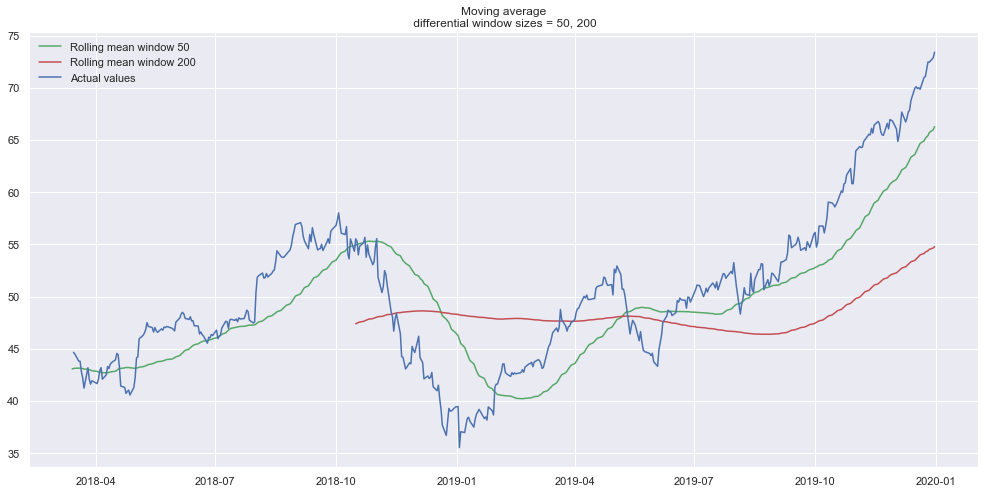

In [24]:
def plot_moving_average_differential(series, window1, window2, plot_intervals=False, scale=1.96):
    rolling_mean1 = series.rolling(window=window1).mean()
    rolling_mean2 = series.rolling(window=window2).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n differential window sizes = ' + str(window1) + ', ' + str(window2))
    plt.plot(rolling_mean1, 'g', label='Rolling mean window ' + str(window1))
    plt.plot(rolling_mean2, 'r', label='Rolling mean window ' + str(window2))

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window1:], rolling_mean[window1:])
        deviation = np.std(series[window1:] - rolling_mean[window1:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window1:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

# differential 50-200
plot_moving_average_differential(aapl['Close'], 50, 200)

A surprisingly ***good*** indicator for buying and selling **AAPL*** stock! When my 50-day rolling mean average (in green) goes below my 200-day rolling mean average (in red), I *indeed* should ***sell***. And when my 50-days crosses above, I *indeed* should ***buy***. That's what I'm going to use from now on!

<br />
<center>
<img src="ipynb.images/funny-fish.gif" width=400 />
    The End
</center>